In [5]:
!pip install opencv-python


  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


In [7]:
! pip install tensorflow seaborn pandas

  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 3.1/390.3 MB 18.5 MB/s eta 0:00:21
    --------------------------------------- 7.3/390.3 MB 18.9 MB/s eta 0:00:21
   - -------------------------------------- 11.0/390.3 MB 18.6 MB/s eta 0:00:21
   - -------------------------------------- 14.9/390.3 MB 18.4 MB/s eta 0:00:21
   - -------------------------------------- 18.6/390.3 MB 18.4 MB/s eta 0:00:21
   -- ------------------------------------- 22.3/390.3 MB 18.3 MB/s eta 0:00:21
   -- ------------------------------------- 26.2/390.3 MB 18.5 MB/s eta 0:00:20
   --- ------------------------------------ 29.9/390.3 MB 18.4 MB/s eta 0:00:20
   --- ------------------------------------ 33.8/390.3 MB 18.4 MB/s eta 0:00:20
   --- ------------------------------------ 37.7/390.3 MB 18.5 MB/s eta 0:00:20
   ---- ----------------------------------- 41.7/390.3 MB 18.4 MB/s e

# Parkinson's Disease Detection using Parkinson's Spiral Drawing and CNN



In [28]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd

### Loading Dataset

In [9]:
data_train = np.load('train_set.npz', allow_pickle=True)
x_train = data_train['arr_0']
y_train = data_train['arr_1']

print(x_train.shape)
print(y_train.shape)

(72, 256, 256, 3)
(72,)


In [10]:
data_test = np.load('test_set.npz', allow_pickle=True)
x_test = data_test['arr_0']
y_test = data_test['arr_1']

print(x_test.shape)
print(y_test.shape)

(30, 256, 256, 3)
(30,)


### Data Distribution

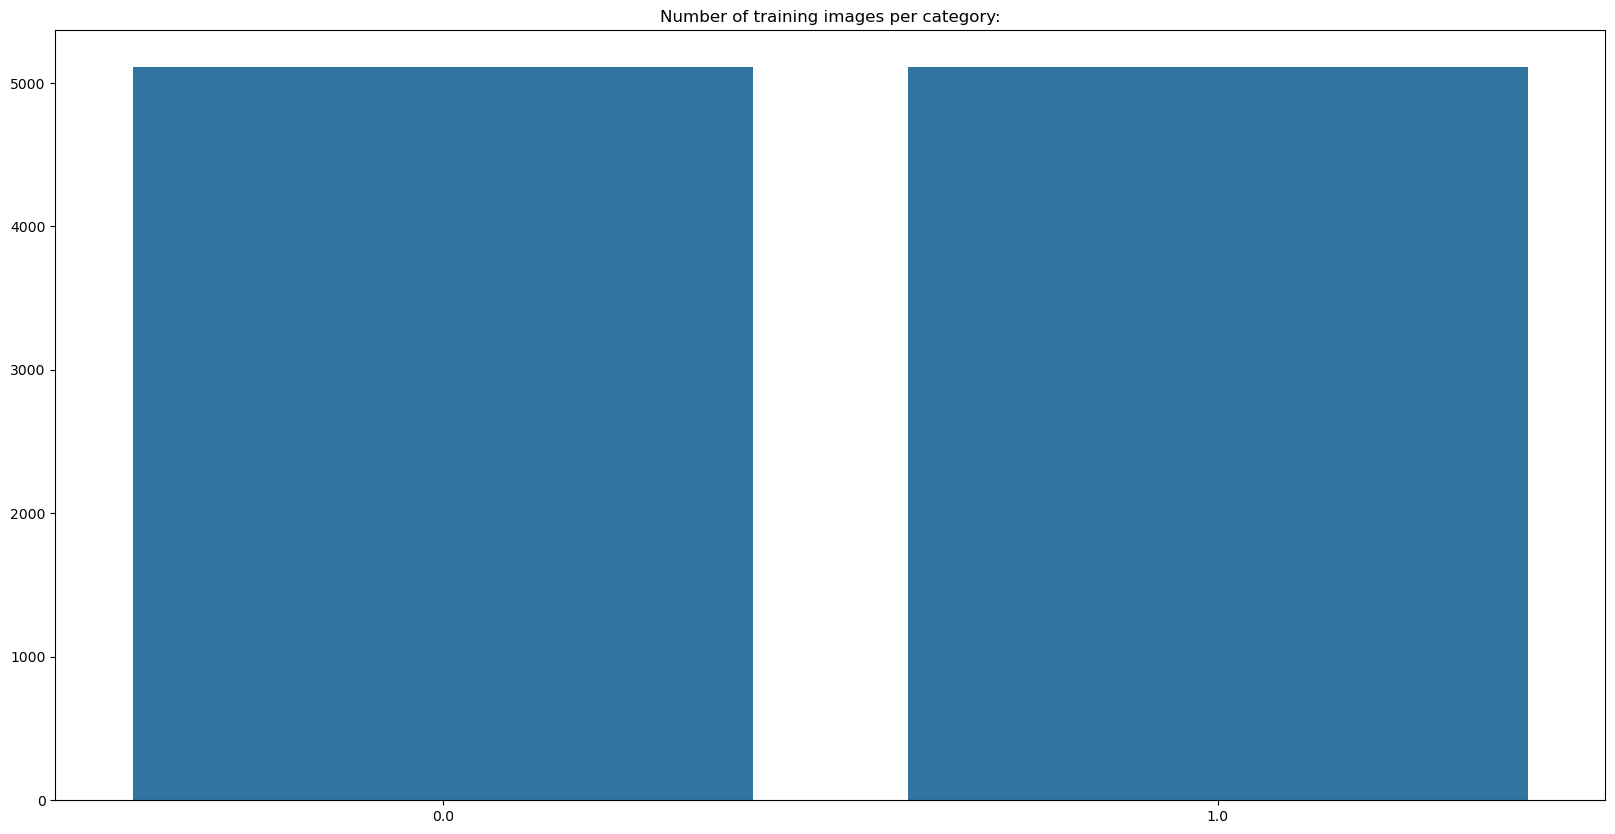

In [25]:
unique_train, count = np.unique(y_train, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=unique_train, y=count).set_title("Number of training images per category:")
plt.show()

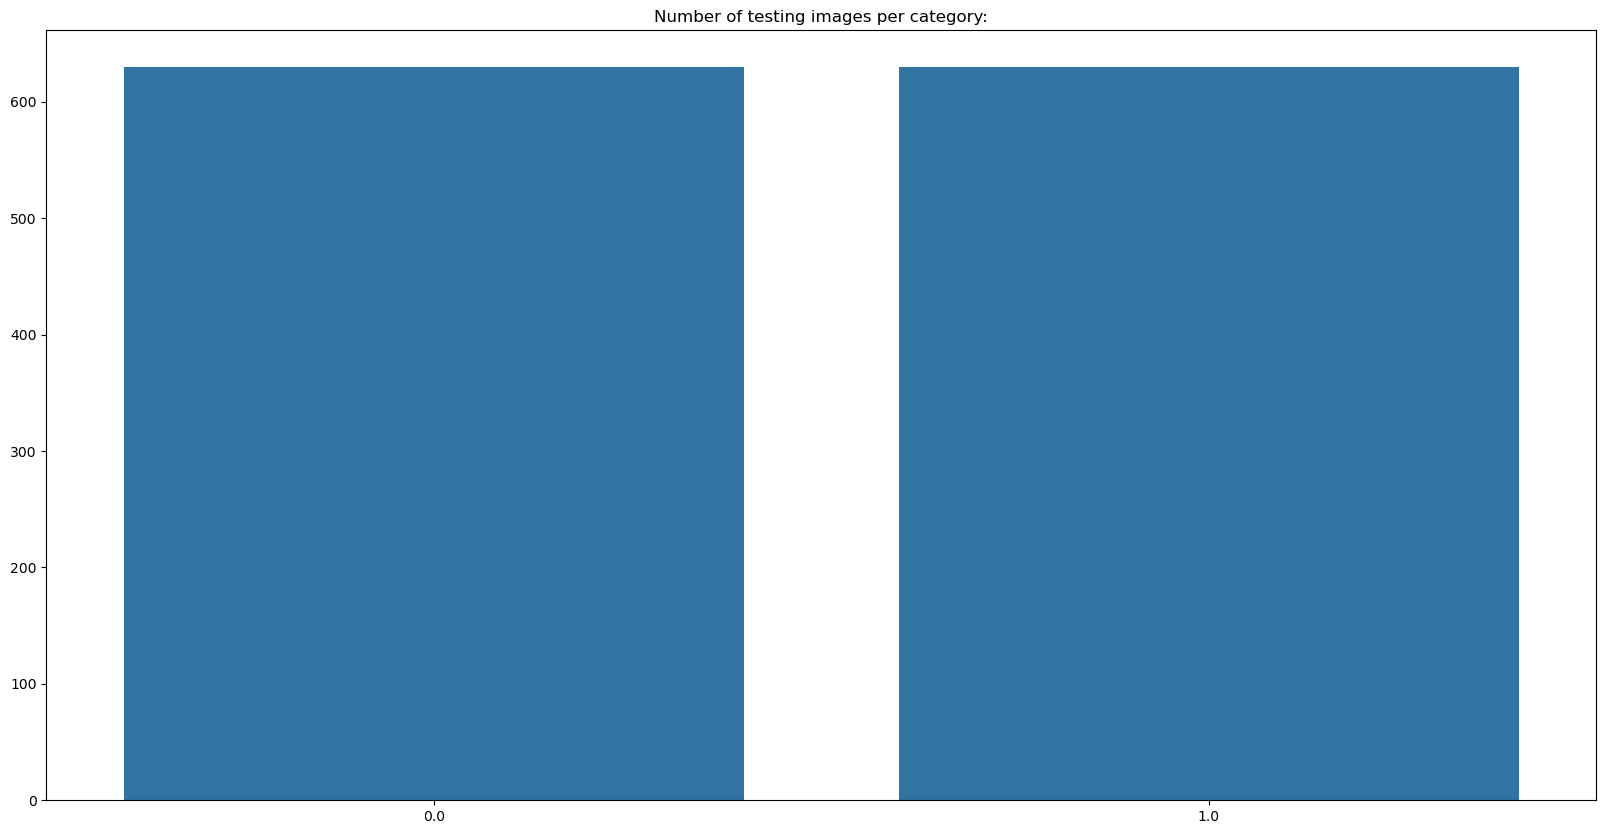

In [26]:
unique_test, count_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=unique_test, y=count_test).set_title("Number of testing images per category:")
plt.show()

As can be seen, though the dataset is balanced but contains very less data points

### Augmenting the Dataset

In [12]:
train_data_generator = ImageDataGenerator(rotation_range=360, 
                                    width_shift_range=0.0, 
                                    height_shift_range=0.0, 
                                    horizontal_flip=True, 
                                    vertical_flip=True)

x = list(x_train)
y = list(y_train)

x_aug_train = []
y_aug_train = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(70):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)
print(len(x_aug_train))
print(len(y_aug_train))

x_train = x + x_aug_train
y_train = y + y_aug_train
print(len(x_train))
print(len(y_train))

test_data_generator = ImageDataGenerator(rotation_range=360, 
                                    width_shift_range=0.0, 
                                    height_shift_range=0.0, 
                                    horizontal_flip=True, 
                                    vertical_flip=True)

x = list(x_test)
y = list(y_test)

x_aug_test = []
y_aug_test = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = test_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(20):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_image)
        y_aug_test.append(v)
print(len(x_aug_test))
print(len(y_aug_test))

x_test = x + x_aug_test
y_test = y + y_aug_test
print(len(x_test))
print(len(y_test))

5040
5040
5112
5112
600
600
630
630


### Visualizing the Images in Train and Test Set

##### Images in Train Set

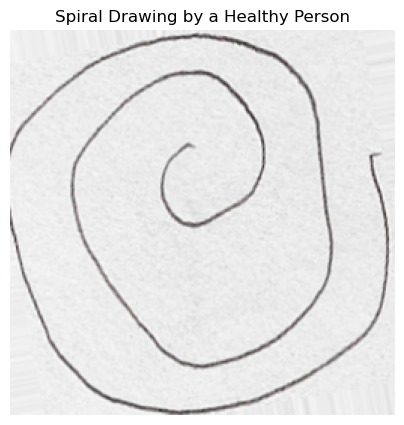

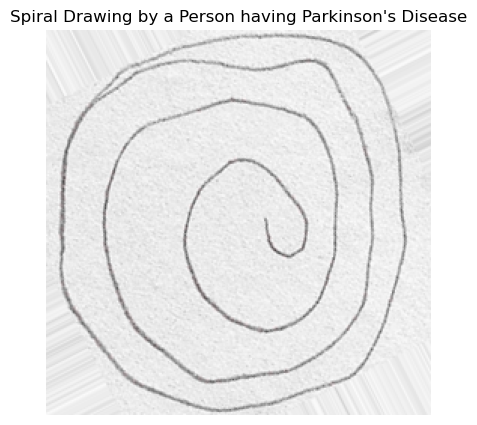

In [13]:
# print(y_test)
figure1 = plt.figure(figsize=(5, 5))
idx_healthy = [i for (i, v) in enumerate(y_train) if v=='healthy']
img_healthy = x_train[idx_healthy[-1]]
plt.imshow(img_healthy)
plt.title('Spiral Drawing by a Healthy Person')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_parkinson = [i for (i, v) in enumerate(y_train) if v=='parkinson']
img_parkinson = x_train[idx_parkinson[-1]]
plt.imshow(img_parkinson)
plt.title("Spiral Drawing by a Person having Parkinson's Disease")
plt.axis('off')
plt.show()

#### Images in Test Set

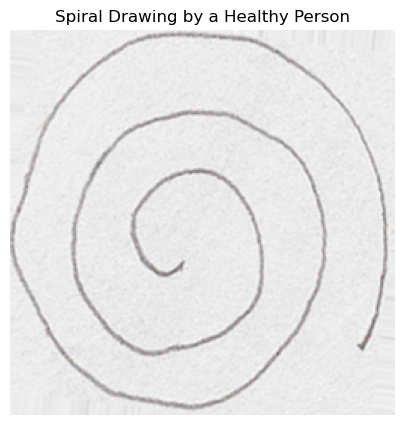

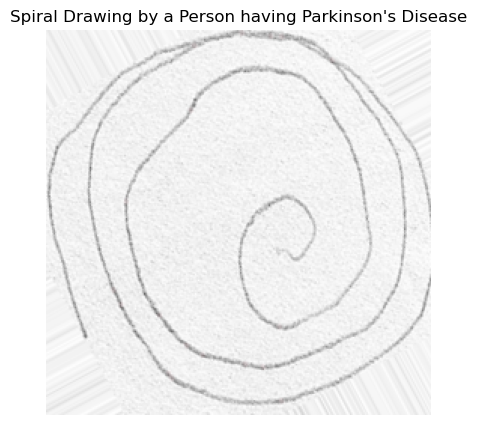

In [14]:
figure1 = plt.figure(figsize=(5, 5))
idx_healthy = [i for (i, v) in enumerate(y_test) if v=='healthy']
img_healthy = x_test[idx_healthy[-1]]
plt.imshow(img_healthy)
plt.title('Spiral Drawing by a Healthy Person')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_parkinson = [i for (i, v) in enumerate(y_test) if v=='parkinson']
img_parkinson = x_test[idx_parkinson[-1]]
plt.imshow(img_parkinson)
plt.title("Spiral Drawing by a Person having Parkinson's Disease")
plt.axis('off')
plt.show()

### Preprocessing the Images

In [15]:
for i in range(len(x_train)):
    img = x_train[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_train[i] = img
    
for i in range(len(x_test)):
    img = x_test[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_test[i] = img

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train/255.0
x_test = x_test/255.0

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print(y_train.shape)

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
print(y_test.shape)

(5112,)
(630,)


### Data Distribution after Augmentation

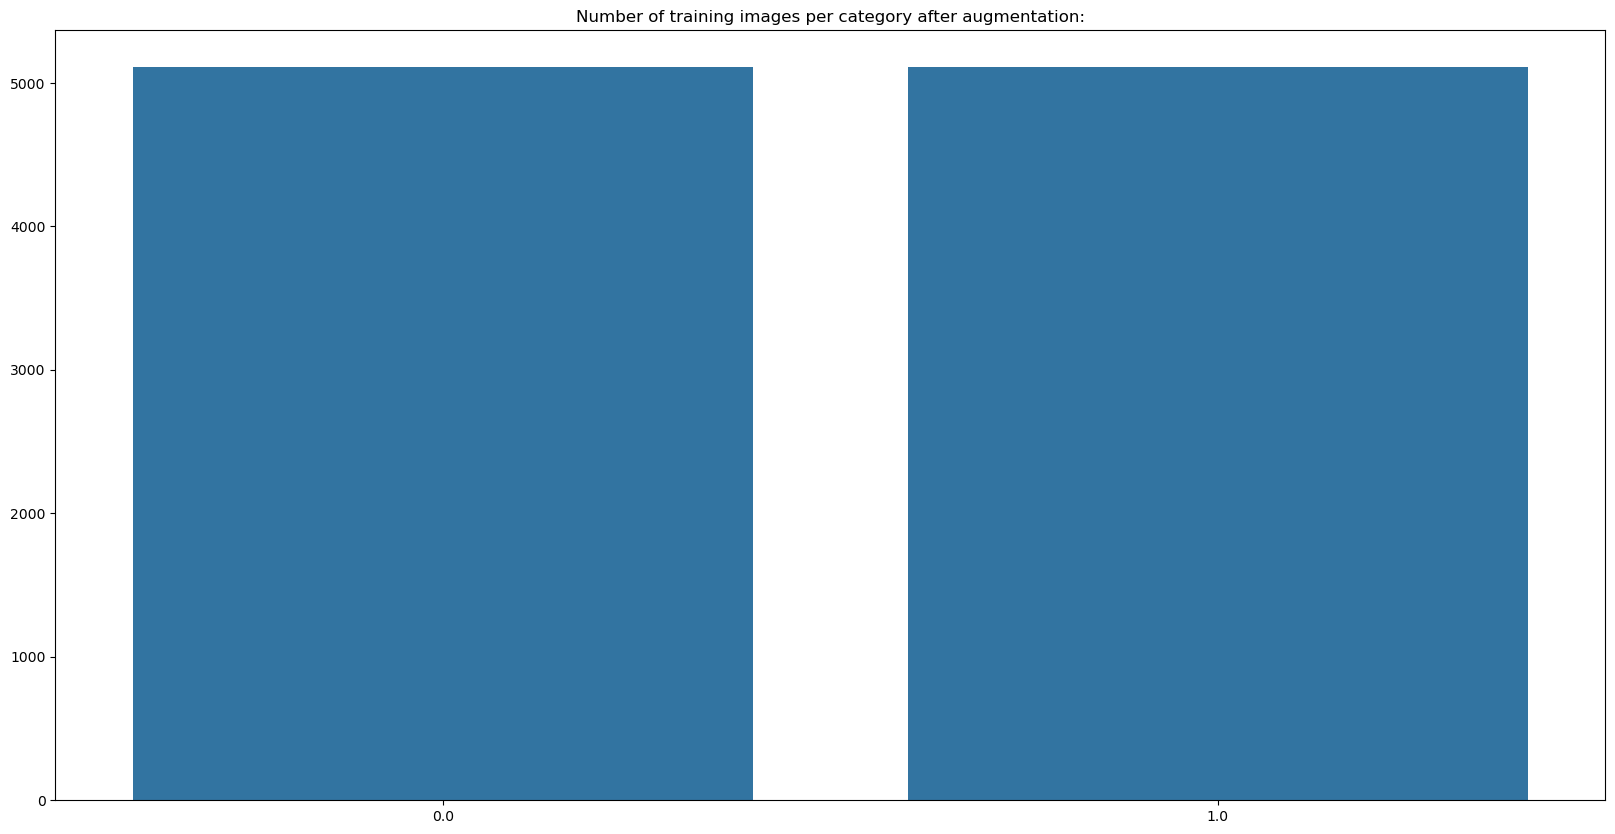

In [23]:
unique_train, count = np.unique(y_train, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=unique_train, y=count).set_title("Number of training images per category after augmentation:")
plt.show()

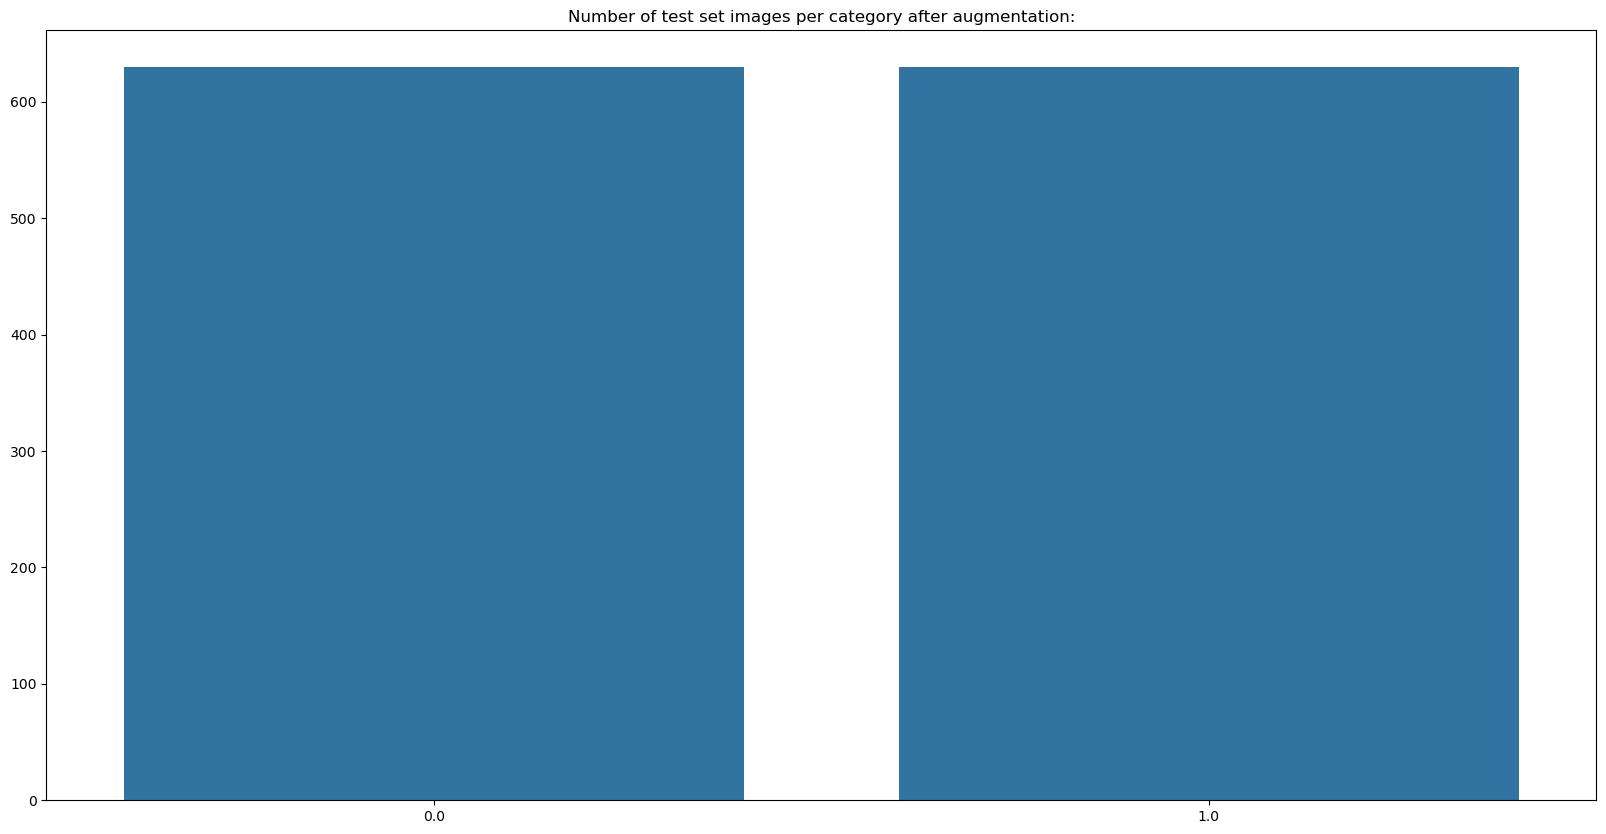

In [24]:
unique_test, count_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=unique_test, y=count_test).set_title("Number of test set images per category after augmentation:")
plt.show()

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5112, 128, 128, 1)
(5112, 2)
(630, 128, 128, 1)
(630, 2)


### Defining the Model

In [19]:
def parkinson_disease_detection_model(input_shape=(128, 128, 1)):
    regularizer = tf.keras.regularizers.l2(0.001)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))

    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))
    
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))    
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))
    
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
model= parkinson_disease_detection_model(input_shape=(128, 128, 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 128, 128, 128)  │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 40, 40, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,146 (930.26 KB)

 Trainable params: 238,146 (930.26 KB)

 Non-trainable params: 0 (0.00 B)

### Training the Model

In [21]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=70, validation_data=(x_test, y_test))

Epoch 1/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5016 - loss: 0.8567 - val_accuracy: 0.5190 - val_loss: 0.8488
Epoch 2/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5032 - loss: 0.8469 - val_accuracy: 0.4968 - val_loss: 0.8411
Epoch 3/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5157 - loss: 0.8395 - val_accuracy: 0.5000 - val_loss: 0.8347
Epoch 4/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5107 - loss: 0.8330 - val_accuracy: 0.5476 - val_loss: 0.8283
Epoch 5/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4976 - loss: 0.8273 - val_accuracy: 0.5397 - val_loss: 0.8220
Epoch 6/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5110 - loss: 0.8212 - val_accuracy: 0.5381 - val_loss: 0.8165
Epoch 7/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5296 - loss: 0.8148 - val_accuracy: 0.5063 - val_loss: 0.8110
Epoch 8/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5291 - loss: 0.8101 - val_accuracy: 0.5444 - val_loss:

### Loss and Accuracy Plot

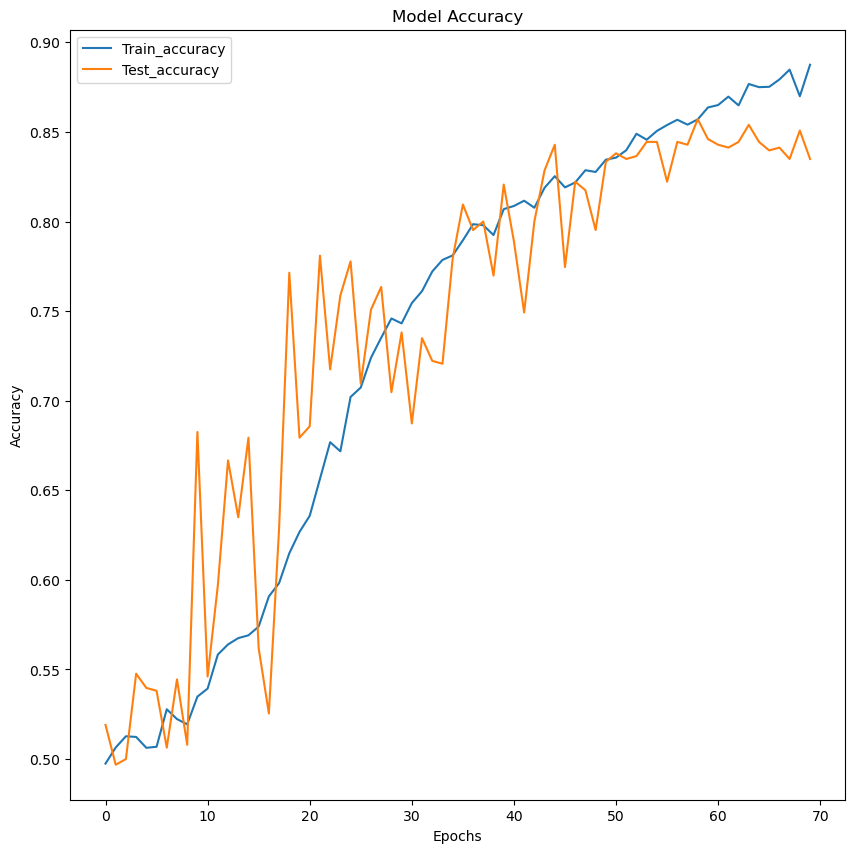

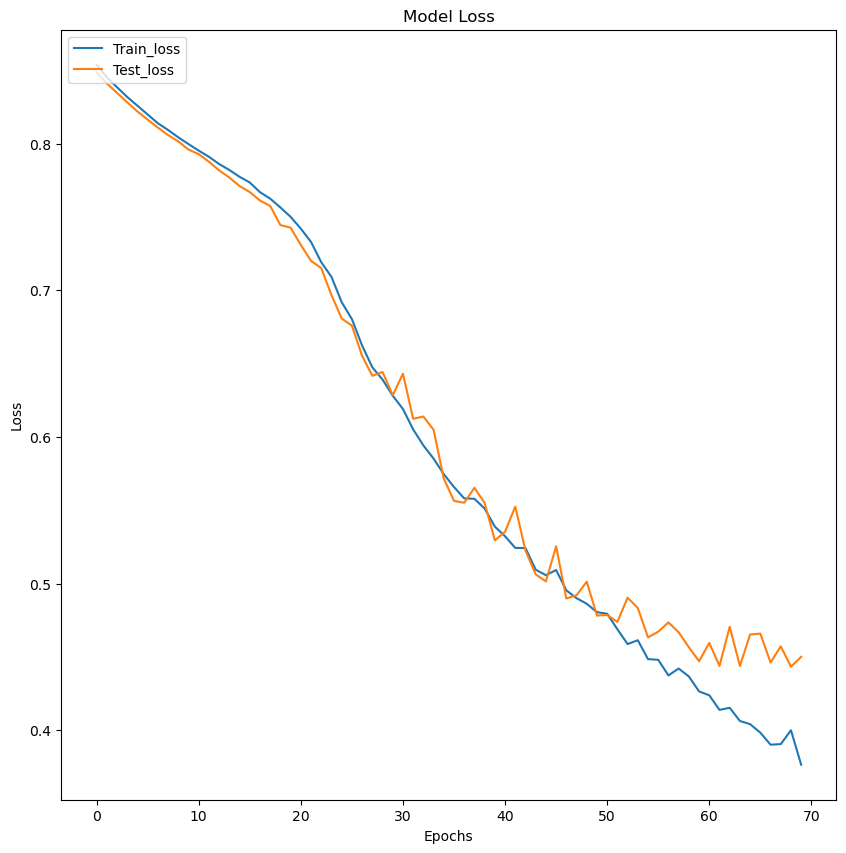

In [22]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

### Classification Report

In [27]:
ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
print(classification_report(y_test_pred, ypred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
              precision    recall  f1-score   support

           0       0.89      0.77      0.82       315
           1       0.79      0.90      0.85       315

    accuracy                           0.83       630
   macro avg       0.84      0.83      0.83       630
weighted avg       0.84      0.83      0.83       630



### Confusion Matrix

<Axes: >

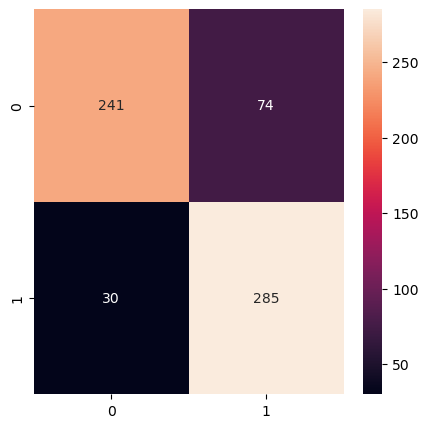

In [28]:
matrix = confusion_matrix(y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

### Saving the Model

In [29]:
model.save('parkinson_disease_detection.h5')

### Testing Model on Images

In [29]:
labels = ['Healthy', 'Parkinson']
image_healthy = cv2.imread('test_image_healthy.png')
image_parkinson = cv2.imread('test_image_parkinson.png')

image_healthy = cv2.resize(image_healthy, (128, 128))
image_healthy = cv2.cvtColor(image_healthy, cv2.COLOR_BGR2GRAY)
image_healthy = np.array(image_healthy)
image_healthy = np.expand_dims(image_healthy, axis=0)
image_healthy = np.expand_dims(image_healthy, axis=-1)

image_parkinson = cv2.resize(image_parkinson, (128, 128))
image_parkinson = cv2.cvtColor(image_parkinson, cv2.COLOR_BGR2GRAY)
image_parkinson = np.array(image_parkinson)
image_parkinson = np.expand_dims(image_parkinson, axis=0)
image_parkinson = np.expand_dims(image_parkinson, axis=-1)

In [30]:
ypred_healthy = model.predict(image_healthy)
ypred_parkinson = model.predict(image_parkinson)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


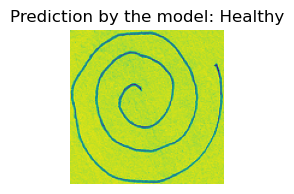

In [33]:
figure = plt.figure(figsize=(2, 2))
img_healthy = np.squeeze(image_healthy, axis=0)
img_healthy = np.squeeze(img_healthy, axis=-1)
plt.imshow(img_healthy)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_healthy[0], axis=0)]}')
plt.show()

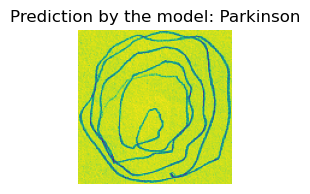

In [34]:
figure = plt.figure(figsize=(2, 2))
image_parkinson = np.squeeze(image_parkinson, axis=0)
image_parkinson = np.squeeze(image_parkinson, axis=-1)
plt.imshow(image_parkinson)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_parkinson[0], axis=0)]}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


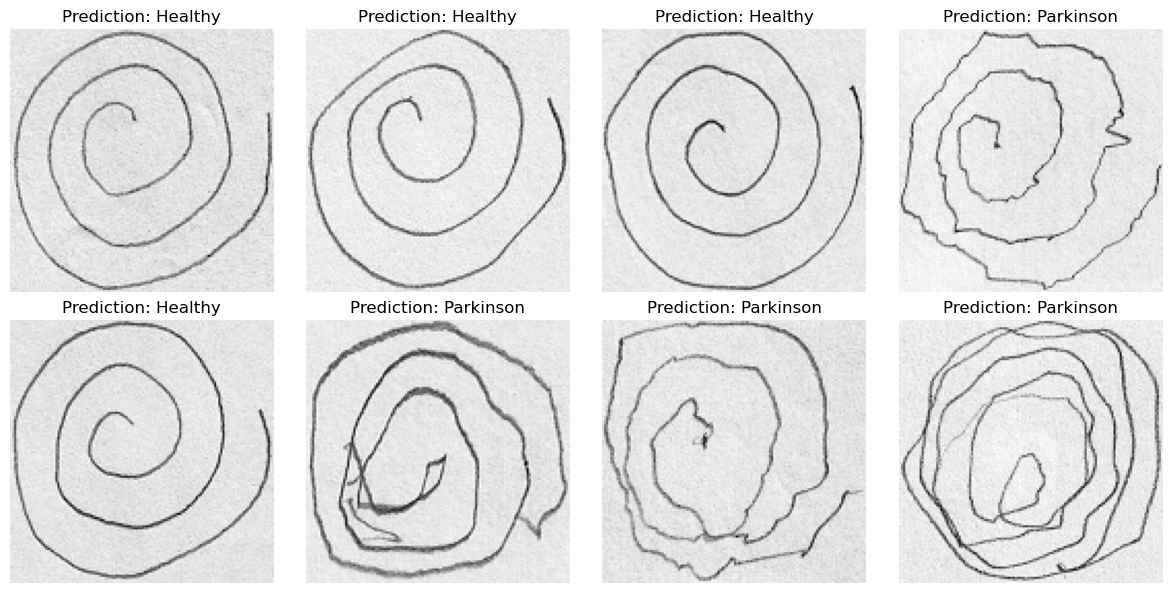

In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Define labels
labels = ['Healthy', 'Parkinson']

# Specify the folder containing images
folder_path = 'TEST'

# Automatically get all image paths from the folder
image_paths = [
    os.path.join(folder_path, file)
    for file in os.listdir(folder_path)
    if file.endswith(('.png', '.jpg', '.jpeg'))  # Filter for image files
]

# Shuffle the image paths to access them in random order
random.shuffle(image_paths)

# Preprocessing function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

# Preprocess all images
images = [preprocess_image(path) for path in image_paths]

# Predict the labels for all images
predictions = [model.predict(image) for image in images]
predicted_labels = [labels[np.argmax(pred[0])] for pred in predictions]

# Plot all images as subplots
fig_rows = (len(images) + 3) // 4  # Calculate rows dynamically (4 images per row)
fig, axes = plt.subplots(fig_rows, 4, figsize=(12, 3 * fig_rows))  # Adjust height dynamically

for i, ax in enumerate(axes.flatten()):
    if i < len(images):
        img = np.squeeze(images[i], axis=0)  # Remove batch dimension
        img = np.squeeze(img, axis=-1)  # Remove channel dimension
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Prediction: {predicted_labels[i]}')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()


In [26]:
import tkinter as tk
from tkinter import messagebox
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import tensorflow as tf

# Load your saved CNN model
model = tf.keras.models.load_model("parkinson_disease_detection.h5")

class ParkinsonsDetectionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Parkinson's Detection")

        # Canvas for drawing
        self.canvas = tk.Canvas(root, width=400, height=400, bg="white")
        self.canvas.grid(row=0, column=0, columnspan=4, padx=10, pady=10)

        self.image = Image.new("RGB", (400, 400), "white")
        self.draw = ImageDraw.Draw(self.image)

        # Buttons
        self.detect_button = tk.Button(root, text="Detect", command=self.detect)
        self.detect_button.grid(row=1, column=0, padx=5, pady=5)

        self.clear_button = tk.Button(root, text="Clear", command=self.clear_canvas)
        self.clear_button.grid(row=1, column=1, padx=5, pady=5)

        # Bind mouse events
        self.canvas.bind("<B1-Motion>", self.paint)
        self.canvas.bind("<ButtonRelease-1>", self.reset_coords)

    def paint(self, event):
        if not hasattr(self, 'last_x') or not hasattr(self, 'last_y'):
            self.last_x, self.last_y = event.x, event.y

        x1, y1 = self.last_x, self.last_y
        x2, y2 = event.x, event.y
        self.canvas.create_line(x1, y1, x2, y2, fill="black", width=2)
        self.draw.line([x1, y1, x2, y2], fill="black", width=2)

        self.last_x, self.last_y = event.x, event.y

    def reset_coords(self, event):
        self.last_x, self.last_y = None, None

    def clear_canvas(self):
        self.canvas.delete("all")
        self.image = Image.new("RGB", (400, 400), "white")
        self.draw = ImageDraw.Draw(self.image)

    def detect(self):
        processed_image = self.image.convert("L")  # Convert to grayscale
        resized_image = processed_image.resize((128, 128))  # Resize for the model
        image_array = np.array(resized_image) / 255.0  # Normalize the image
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        image_array = np.expand_dims(image_array, axis=-1)  # Add channel dimension if required

        prediction = model.predict(image_array)
        m=max(prediction[0][0],prediction[0][1])
        if prediction[0][1]<0 and prediction[0][0]>0.99993500000:
            result = f" Detected class 0: {prediction[0][0]}\nPrediction for class 1: {prediction[0][1]}"
        else:
            result = f" Not class 0: {prediction[0][0]}\nPrediction for class 1: {prediction[0][1]}"
        messagebox.showinfo("Detection Result", result)

# Create the main Tkinter window
root = tk.Tk()
app = ParkinsonsDetectionApp(root)
root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
